This will look at the MSC cells, both RNA and ATAC Seq results. 
The RNA-Seq is exported from step_0 as adata_sel_updated, cluster 1 is MSC. The samples included are from MA9 models, doublet removed, clean samples. And can be loaded as

```python
adata_sel_updated = ad.read_h5ad('data/adata_sel_udpate_may07.h5ad') 
```

ATAC seq results is based on nb_niche_snapATAC2_May1.ipynb, but the atac data for MSC need to start from the fragment file to recall the peaks et al.   

```python
atac = snap.read_dataset("nb_niche_snapATA2_all_atac_sample.h5ads")
```


# import package


In [ ]:
import rpy2.robjects as ro
%load_ext rpy2.ipython 


In [ ]:
import os
import pandas as pd
import re
from muon import atac as ac
import numpy as np
import scanpy as sc
import anndata as ad
import muon as mu
import scipy
from scipy import sparse
import copy

import seaborn as sns
import scrublet as scr

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import bbknn

#mport celltypist
#from celltypist import models

# Inital setting for plot size
from matplotlib import rcParams

FIGSIZE = (3, 3)
plt.rcParams["figure.figsize"] = FIGSIZE

from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
display(HTML("<style>.output_result { max-width:100% !important; }</style>")) 

os.environ["PATH"] = os.environ["PATH"] + ':' + '/home/whu78/conda3/envs/feb24/bin:/home/whu78/conda3/envs/feb24/condabin:/hpcf/user_commands:/usr/NX/bin:/cm/local/apps/environment-modules/4.5.3/bin:/hpcf/lsf/lsf_prod/10.1/linux3.10-glibc2.17-x86_64/etc:/hpcf/lsf/lsf_prod/10.1/linux3.10-glibc2.17-x86_64/bin:/usr/lpp/mmfs/bin:/usr/lpp/mmfs/lib:/usr/local/bin:/usr/bin:/usr/local/sbin:/usr/sbin:/sbin:/usr/sbin:/cm/local/apps/environment-modules/4.5.3/bin:/usr/sbin:/sbin:/bin:/usr/bin:/etc:/usr/ucb:/usr/local/bin:/usr/local/local_dfs/bin:/usr/bin/X11:/usr/local/sas:/home/whu78/.local/bin:/home/whu78/bin'

from itables import init_notebook_mode
init_notebook_mode(all_interactive=True)

%matplotlib inline

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category = UserWarning)
warnings.filterwarnings("ignore", category = RuntimeWarning)


In [4]:
%%R -i base_dir
library(data.table)
library(dplyr)
library(ggplot2)
library(IRdisplay)

setwd(base_dir)

options(width = 200)


In [ ]:
design = pd.read_table('data/dsn_dt_base_v2.tsv')
design


# load data

In [37]:
rna = ad.read_h5ad('data/adata_sel_udpate_may07.h5ad')


In [38]:
# extract MSC cluster
msc_rna = rna[rna.obs['leiden'] == '1']
obs_df = msc_rna.obs

# rename one of the sample name, this is a second sequencing for the same library
obs_df.loc[obs_df['sampleID'] == 'M4_m10', 'sampleID'] = 'M4'
msc_rna.obs['sampleID'] = obs_df['sampleID'].cat.remove_unused_categories()


[<Axes: title={'center': 'sampleID'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <Axes: title={'center': 'leiden'}, xlabel='UMAP1', ylabel='UMAP2'>]

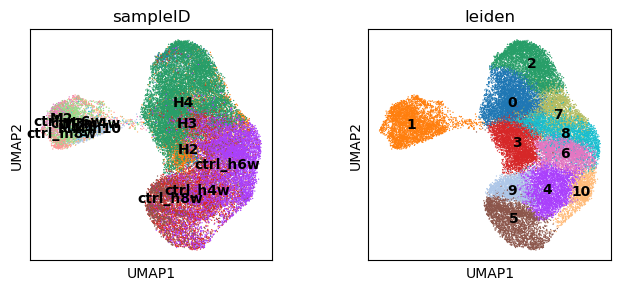

In [39]:
sc.pl.umap(rna, color = ['sampleID', 'leiden'], show = False, legend_loc = 'on data')


[<Axes: title={'center': 'sampleID'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <Axes: title={'center': 'leiden'}, xlabel='UMAP1', ylabel='UMAP2'>]

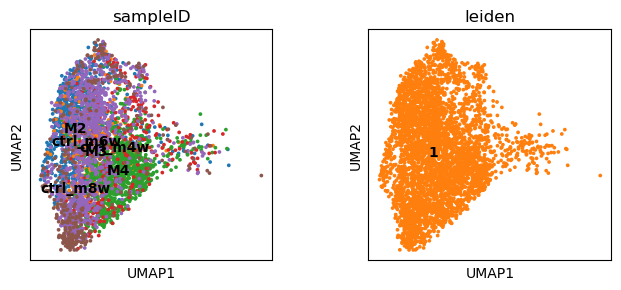

In [40]:
sc.pl.umap(msc_rna, color = ['sampleID', 'leiden'], show = False, legend_loc = 'on data')


In [41]:
msc_rna.obs.shape

(4124, 58)

[Text(0, 0, '1028'),
 Text(0, 0, '357'),
 Text(0, 0, '1017'),
 Text(0, 0, '319'),
 Text(0, 0, '1062'),
 Text(0, 0, '341')]

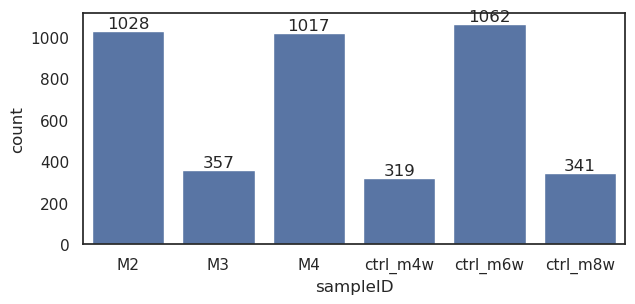

In [44]:
sns.set_theme(rc={'figure.figsize':(7,3)})
sns.set_theme(style="white", palette=None)
ax = sns.countplot(msc_rna.obs, x="sampleID")
ax.bar_label(ax.containers[0])


In [45]:
ma9_msc_samples = ['M2', 'M3', 'M4', 'M4_m10', 'ctrl_m4w', 'ctrl_m6w', 'ctrl_m8w']

In [48]:
msc_rna.obs['sampleID'].value_counts() 


sampleID
ctrl_m6w    1062
M2          1028
M4          1017
M3           357
ctrl_m8w     341
ctrl_m4w     319
Name: count, dtype: int64

In [60]:
msc_design = design.loc[design.sample_name.isin(ma9_msc_samples)]
msc_design.to_csv('data/msc_design.csv')


# MSC RNA only analysis

In [49]:
sc.pp.highly_variable_genes(msc_rna, n_top_genes = 2000, flavor = "cell_ranger", batch_key = 'sampleID' )
n_batches = msc_rna.var["highly_variable_nbatches"].value_counts()
msc_rna_hvg = msc_rna[:, msc_rna.var["highly_variable"]].copy()
msc_rna_hvg
neighbors_within_batch = 25 if msc_rna_hvg.n_obs > 100000 else 3
msc_rna_bbknn = msc_rna_hvg.copy()
msc_rna_bbknn.X = msc_rna_bbknn.layers["counts"].copy()
sc.pp.pca(msc_rna_bbknn)
bbknn.bbknn( msc_rna_bbknn, batch_key='sampleID', neighbors_within_batch=neighbors_within_batch )
sc.tl.umap(msc_rna_bbknn)
sc.tl.leiden(msc_rna_bbknn, resolution = 1)


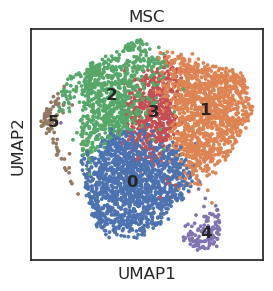

In [50]:
plt.rcParams['figure.figsize'] = 3,3 
sc.tl.leiden(msc_rna_bbknn, resolution = .55, )
ax = sc.pl.umap(msc_rna_bbknn, color = ['leiden'], show = False, legend_loc = 'on data', title = 'MSC')
x_min, x_max = ax.get_xlim()
y_min, y_max = ax.get_ylim()


In [51]:
# add bbknn results to the original object with full expression data
msc_rna.obs = msc_rna_bbknn.obs
msc_rna.uns = msc_rna_bbknn.uns
msc_rna.obsm = msc_rna_bbknn.obsm


In [33]:
msc_rna_bbknn.write_h5ad('data/msc_rna_bbknn_nb_niche_scRNA_2024May06.h5ad')
msc_rna_bbknn


AnnData object with n_obs × n_vars = 4132 × 2000
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'leiden', 'ngfr_predicted_labels', 'ngfr_over_clustering', 'ngfr_majority_voting', 'ngfr_conf_score', 'wk4_predicted_labels', 'wk4_over_clustering', 'wk4_majority_voting', 'wk4_conf_score', 'wk6_predicted_labels', 'wk6_over_clustering', 'wk6_majority_voting', 'wk6_conf_score', 'wk8_predicted_labels', 'wk8_over_clustering', 'wk8_majority_voting', 'wk8_conf_score', 'oldway_predicted_labels', 'oldway_over_clustering', 'oldway_majority_voting', 'oldway_conf_score', 'dp_predicted_labels', 'dp_over_clustering', 'dp_majority_voting', 'dp_conf_score', 'hspc_predicted_labels', 'hspc_over_clustering', 'hspc_majority_voting', 'hspc_conf_score', 'celltype_d1_predicted_labels', 'celltype_d1_over_clustering', 'celltype_d1_majority_voting', 'celltype_d1_conf_score', 'hNFGR_predicted_labels', 'hNFG

In [ ]:
#msc_rna_bbknn = ad.read_h5ad('data/msc_rna_bbknn_nb_niche_scRNA_2024May06.h5ad')


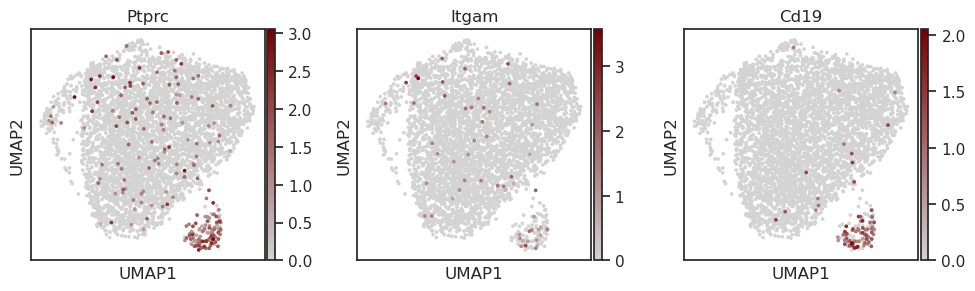

In [53]:
plt.rcParams['figure.figsize'] = 3,3 
ax = sc.pl.umap(msc_rna, color = ['Ptprc', 'Itgam', 'Cd19'], show = False, legend_loc = 'on data',
                cmap=sns.blend_palette(["lightgray", sns.xkcd_rgb["blood"]], as_cmap=True) ) 
# Ptprc (CD45)”, “Itgam (Mac-1)”, and “Cd19


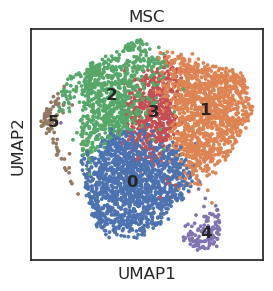

In [54]:
plt.rcParams['figure.figsize'] = 3,3 
ax = sc.pl.umap(msc_rna, color = ['leiden'], show = False, legend_loc = 'on data', title = 'MSC')
x_min, x_max = ax.get_xlim()
y_min, y_max = ax.get_ylim()


In [1]:
aa = ['MA9_MSC_wk4__AGAAAGGCACCTACTT-1_1', 'MA9_MSC_wk4__CAGGGCTTCACCATTT-1_1', 'MA9_MSC_wk4__GATTGCAGTGTAACCA-1_1', 'MA9_MSC_wk8__ACCTAAATCTTTAGGA-1_4', 'MA9_MSC_wk8__ACTCACCTCCCGTTTA-1_4', 'MA9_MSC_wk8__CGCTGTGCATGAAATG-1_4', 'MA9_MSC_wk8__CGTGCTGCAAACGCGA-1_4', 'MA9_MSC_wk8__GTTAGGCGTGGACATC-1_4', 'MA9_MSC_wk8__TCTACTAGTAATCGCA-1_4', 'Ctrl_MSC_wk6__AAGACCAAGTGAGCGG-1_6', 'Ctrl_MSC_wk6__AATCCCTGTTGTAAAC-1_6', 'Ctrl_MSC_wk6__AATTAGCGTTAGGCTA-1_6', 'Ctrl_MSC_wk6__CTATTACTCGGTCAAT-1_6', 'Ctrl_MSC_wk6__GAGAAACGTTTATTCG-1_6', 'Ctrl_MSC_wk6__GATTCAGGTGATTACG-1_6', 'Ctrl_MSC_wk6__GGGTTTGTCCCTCAAC-1_6', 'Ctrl_MSC_wk6__TAGCGCGGTCTTACTA-1_6', 'Ctrl_MSC_wk6__TCATTTGGTTAGCCAA-1_6', 'Ctrl_MSC_wk6__TGAGGGAGTGTTTGCT-1_6', 'Ctrl_MSC_wk6__TTCAGCACATAGACCC-1_6', 'Ctrl_MSC_wk6__TTTAACGAGGAGGTTA-1_6', 'Ctrl_MSC_wk6__TTTGCATTCACTTTAC-1_6', 'Ctrl_MSC_wk8__TCTTAGTTCGTCATTT-1_7']


In [55]:
# remove hematopoietic cells in these MSC cells. 
msc_rna_2 = msc_rna[msc_rna.obs['leiden'].isin(['0', '1', '2', '3'])]


In [57]:
# re-run bbknn
sc.pp.highly_variable_genes(msc_rna_2, n_top_genes = 2000, flavor = "cell_ranger", batch_key = 'sampleID' )
n_batches = msc_rna_2.var["highly_variable_nbatches"].value_counts()
msc_rna_2_hvg = msc_rna_2[:, msc_rna_2.var["highly_variable"]].copy()
msc_rna_2_hvg
neighbors_within_batch = 25 if msc_rna_2_hvg.n_obs > 100000 else 3
msc_rna_2_bbknn = msc_rna_2_hvg.copy()
msc_rna_2_bbknn.X = msc_rna_2_bbknn.layers["counts"].copy()
sc.pp.pca(msc_rna_2_bbknn)
bbknn.bbknn( msc_rna_2_bbknn, batch_key='sampleID', neighbors_within_batch=neighbors_within_batch )
sc.tl.umap(msc_rna_2_bbknn)
sc.tl.leiden(msc_rna_2_bbknn, resolution = 1)


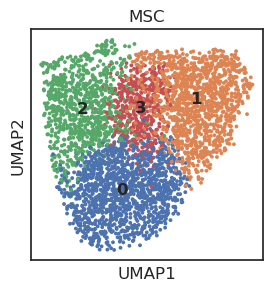

In [58]:
plt.rcParams['figure.figsize'] = 3,3 
sc.tl.leiden(msc_rna_2_bbknn, resolution = .55, )
ax = sc.pl.umap(msc_rna_2_bbknn, color = ['leiden'], show = False, legend_loc = 'on data', title = 'MSC')
x_min, x_max = ax.get_xlim()
y_min, y_max = ax.get_ylim()


In [69]:
# add bbknn results to the original object with full expression data
msc_rna_2.obs = msc_rna_2_bbknn.obs
msc_rna_2.uns = msc_rna_2_bbknn.uns
msc_rna_2.obsm = msc_rna_2_bbknn.obsm


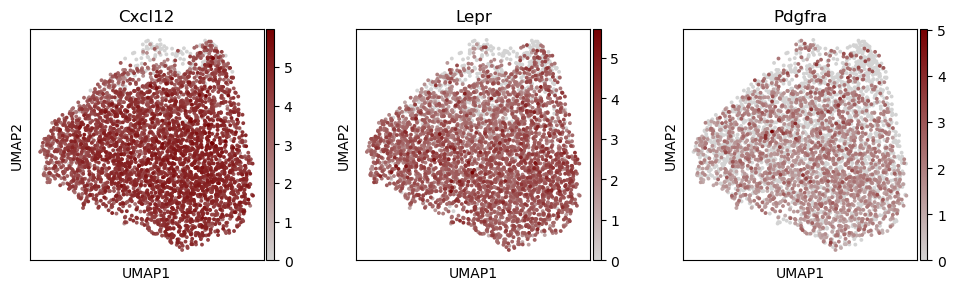

In [73]:
plt.rcParams['figure.figsize'] = 3,3 
ax = sc.pl.umap(msc_rna_2_bbknn, color = ['Cxcl12', 'Lepr', 'Pdgfra'], show = False, legend_loc = 'on data',
                                                  cmap=sb.blend_palette(["lightgray", sb.xkcd_rgb["blood"]], as_cmap=True) ) 


[Text(0, 0, '708'), Text(0, 0, '498'), Text(0, 0, '646'), Text(0, 0, '468')]

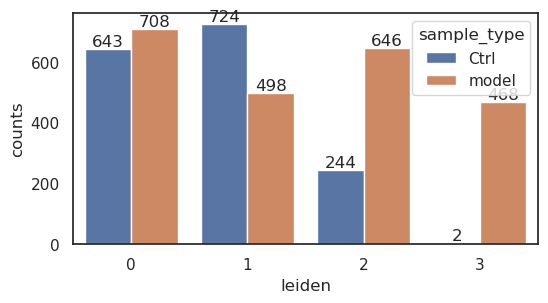

In [61]:
obs_vc = msc_rna_2_bbknn.obs[['sampleID', 'leiden']].value_counts().to_frame('counts').reset_index()
obs_vc = obs_vc.merge(msc_design[['sampleID', 'sample_name', 'sample_type']], left_on = 'sampleID', right_on = 'sample_name', how = 'left')
#obs_vc.groupby(['sampleID_y', 'leiden', 'sample_type']).sum().reset_index()
obs_vc = obs_vc.groupby(['leiden', 'sample_type']).sum().reset_index()
plt.rcParams['figure.figsize'] = 6, 3
ax = sns.barplot(obs_vc, x = 'leiden', y = 'counts', hue = 'sample_type')
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])


Text(0, 0.5, '% cells in cluster 1 or 3')

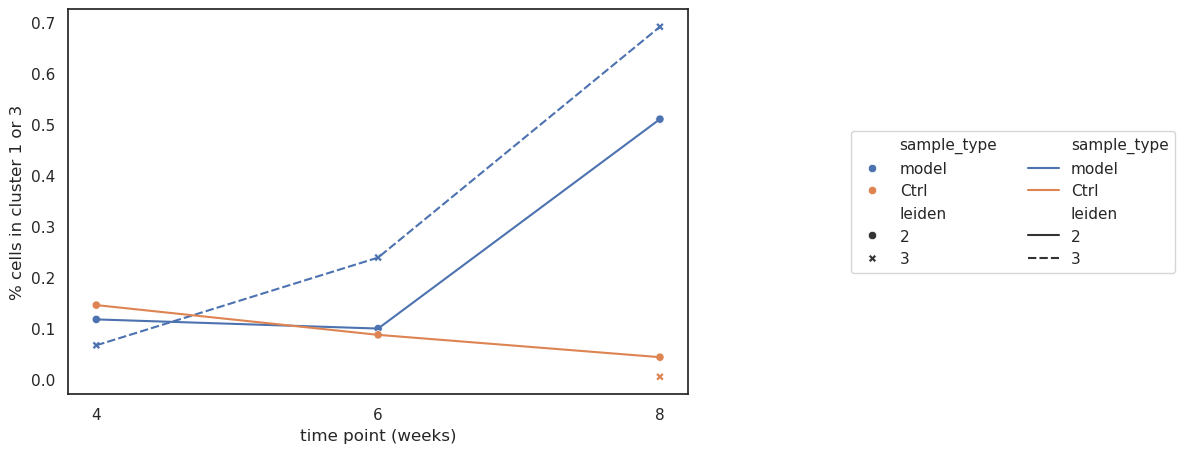

In [63]:
# Dynamics of Cell Composition Across Disease Progression Time Points
obs_vc = msc_rna_2_bbknn.obs[['sampleID', 'leiden']].value_counts().to_frame('counts').reset_index()
obs_vc = obs_vc.merge(msc_design[['sampleID', 'sample_name', 'sample_type', 'time_point']], left_on = 'sampleID', right_on = 'sample_name', how = 'left')
obs_vc = obs_vc.loc[obs_vc['leiden'].isin(['2', '3'])]
obs_vc['percentage'] = obs_vc['counts'] / obs_vc.groupby(['leiden'])['counts'].transform('sum')
obs_vc['time_point'] = obs_vc['time_point'].astype('category')
obs_vc['leiden'] = obs_vc['leiden'].cat.remove_unused_categories()
plt.rcParams['figure.figsize'] = 8, 5
ax = sns.scatterplot(obs_vc, x = 'time_point', y = 'percentage', hue = 'sample_type', style = 'leiden')
sns.lineplot(obs_vc, x = 'time_point', y = 'percentage', hue = 'sample_type', style = 'leiden')
ax.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=2)
ax.set_xlabel('time point (weeks)')
ax.set_ylabel('% cells in cluster 1 or 3')


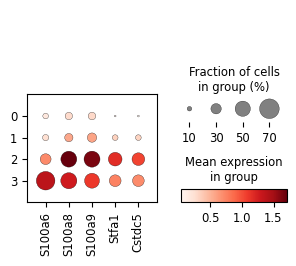

In [88]:
ax = sc.pl.dotplot(msc_rna_2, ['S100a6', 'S100a8', 'S100a9', 'Stfa1', 'Cstdc5'], groupby='leiden') 


In [64]:
msc_rna_2_bbknn.obs[['sampleID', 'leiden']].value_counts()

sampleID  leiden
M2        0         578
ctrl_m6w  0         490
M4        2         454
ctrl_m6w  1         432
M4        3         325
M2        1         244
M4        1         201
ctrl_m8w  1         191
ctrl_m4w  2         129
M3        3         112
M2        2         104
ctrl_m4w  1         101
M3        0         101
          2          88
ctrl_m6w  2          77
ctrl_m4w  0          77
ctrl_m8w  0          76
M3        1          53
ctrl_m8w  2          38
M2        3          31
M4        0          29
ctrl_m8w  3           2
Name: count, dtype: int64

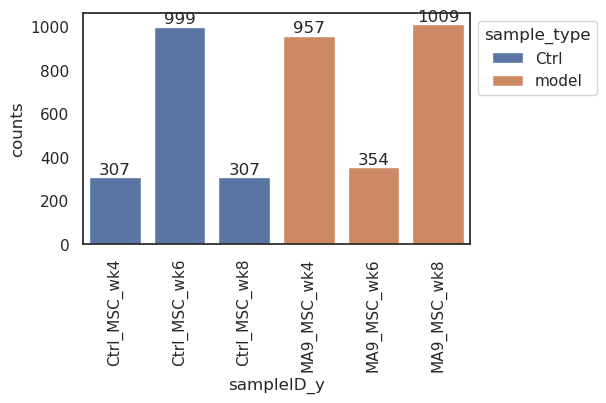

In [69]:
obs_vc = msc_rna_2_bbknn.obs[['sampleID', 'leiden']].value_counts().to_frame('counts').reset_index()
obs_vc = obs_vc.merge(msc_design[['sampleID', 'sample_name', 'sample_type']], left_on = 'sampleID', right_on = 'sample_name', how = 'left')
#obs_vc.groupby(['sampleID_y', 'leiden', 'sample_type']).sum().reset_index()
obs_vc = obs_vc.groupby(['sampleID_y', 'sample_type']).sum('count').reset_index()
plt.rcParams['figure.figsize'] = 5, 3
ax = sns.barplot(obs_vc, x = 'sampleID_y', y = 'counts', hue = 'sample_type')
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])
plt.xticks(rotation=90)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))


# export the results from MSC RNA analysis

msc_rna_2.write_h5ad('data/msc_rna_2_may23.h5ad')
msc_rna.write_h5ad('data/msc_rna_may23.h5ad')


In [6]:
# msc_rna = ad.read_h5ad('data/msc_rna_may23.h5ad')
# msc_rna_2 = ad.read_h5ad('data/msc_rna_2_may23.h5ad')


In [175]:
%%time
snap.pp.mnc_correct(data, batch="sample")
snap.pp.harmony(data, batch="sample", max_iter_harmony=20)


2024-05-08 09:13:21,163 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-05-08 09:13:21 - INFO - Computing initial centroids with sklearn.KMeans...
2024-05-08 09:13:37,300 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-05-08 09:13:37 - INFO - sklearn.KMeans initialization complete.
2024-05-08 09:13:37,822 - harmonypy - INFO - Iteration 1 of 20
2024-05-08 09:13:37 - INFO - Iteration 1 of 20
2024-05-08 09:14:18,788 - harmonypy - INFO - Iteration 2 of 20
2024-05-08 09:14:18 - INFO - Iteration 2 of 20
2024-05-08 09:15:00,475 - harmonypy - INFO - Iteration 3 of 20
2024-05-08 09:15:00 - INFO - Iteration 3 of 20
2024-05-08 09:15:40,752 - harmonypy - INFO - Converged after 3 iterations
2024-05-08 09:15:40 - INFO - Converged after 3 iterations


CPU times: user 1h 55min 2s, sys: 53.6 s, total: 1h 55min 56s
Wall time: 5min 40s


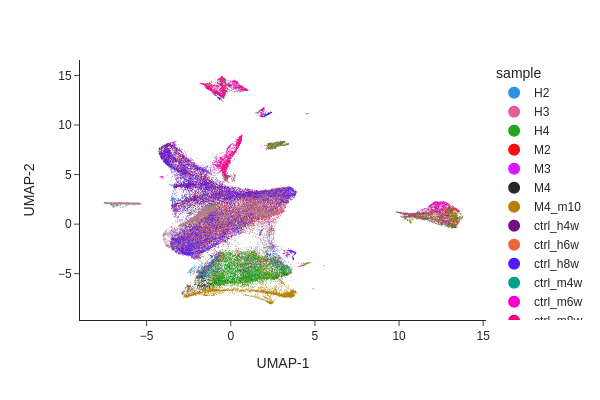

In [176]:
# mnn correction 
snap.tl.umap(data, use_rep="X_spectral_mnn")
snap.pl.umap(data, color="sample", interactive=False)


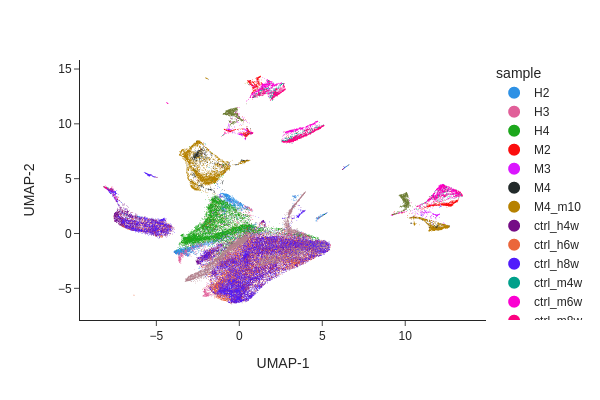

In [177]:
# harmony correction 
snap.tl.umap(data, use_rep="X_spectral_harmony")
snap.pl.umap(data, color="sample", interactive=False)


In [178]:
# clustering analysis 
snap.pp.knn(data, use_rep="X_spectral_harmony")
snap.tl.leiden(data)


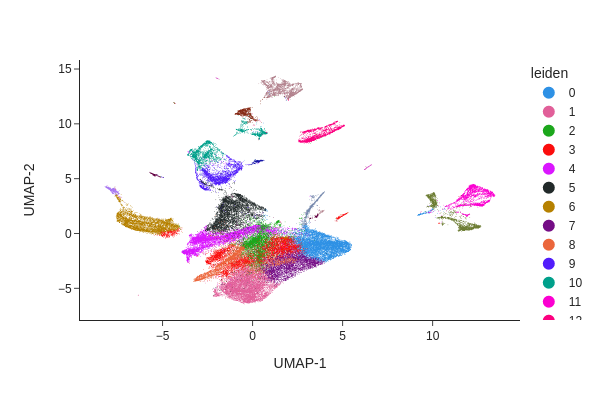

In [179]:
snap.pl.umap(data, color="leiden", interactive=False)


In [180]:
%%time
snap.tl.macs3(data, groupby='leiden', replicate='sample')


2024-05-08 09:18:31 - INFO - Exporting fragments...
2024-05-08 09:22:21 - INFO - Calling peaks...
100%|██████████| 22/22 [35:54<00:00, 97.93s/it] 


CPU times: user 7min 49s, sys: 1min 7s, total: 8min 56s
Wall time: 39min 45s


In [17]:
merged_peaks = snap.tl.merge_peaks(data.uns['macs3'], chrom_sizes=snap.genome.hg38)
merged_peaks.shape


(149, 23)

In [20]:
merged_peaks['Peaks'][1]

'chr1:93478183-93478684'

In [14]:
data = atac

In [21]:
peak_mat = snap.pp.make_peak_matrix(data, use_rep=merged_peaks['Peaks'])
peak_mat


AnnData object with n_obs × n_vars = 78907 × 149
    obs: 'sample', 'leiden', 'tsse'

In [23]:
peak_mat

AnnData object with n_obs × n_vars = 78907 × 149
    obs: 'sample', 'leiden', 'tsse'

In [24]:
marker_peaks = snap.tl.marker_regions(peak_mat, groupby='leiden', pvalue=0.01)


In [26]:
marker_peaks

{}

In [ ]:
snap.pl.regions(peak_mat, groupby='leiden', peaks=marker_peaks, interactive=False)


In [ ]:
motifs = snap.tl.motif_enrichment(
    motifs=snap.datasets.cis_bp(unique=True),
    regions=marker_peaks,
    genome_fasta=snap.genome.hg38,
)


In [ ]:
snap.pl.motif_enrichment(motifs, max_fdr=0.0001, height=1600, interactive=False)


In [110]:
merged_peaks

Peaks,12,14,15,16,13,4,0,6,19,7,8,11,2,10,1,5,9,18,17,3,21,20
str,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool
"""chr1:91249954-…",false,false,false,false,false,false,false,false,false,false,false,false,false,false,true,false,false,false,false,false,false,false
"""chr1:93478183-…",false,false,false,false,false,false,false,true,false,false,false,false,false,true,false,false,false,false,false,false,false,false
"""chr1:131096741…",false,false,false,false,false,false,false,false,false,false,false,false,false,true,false,false,false,false,false,false,false,false
"""chr1:131097608…",false,false,false,false,false,false,false,false,false,false,false,false,false,true,false,false,false,false,false,false,false,false
"""chr1:161034811…",false,false,false,false,false,false,false,true,false,false,false,false,false,false,false,false,false,false,false,false,false,false
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""chr9:110281066…",false,false,false,false,false,false,false,false,false,false,false,false,false,false,true,false,false,false,false,false,false,false
"""chr9:111271476…",false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,true,false
"""chr9:123461761…",false,false,false,false,false,false,false,true,false,false,false,false,false,false,false,false,false,false,false,false,false,false


In [184]:
data

AnnDataSet object with n_obs x n_vars = 78907 x 526765 backed at 'nb_niche_snapATA2_all_atac_sample.h5ads'
contains 15 AnnData objects with keys: 'H2', 'H3', 'H4', 'ctrl_h4w', 'ctrl_h6w', 'ctrl_h8w', 'M2', 'M3', 'M4', 'M4_m10', 'ctrl_m4w', 'ctrl_m6w', 'ctrl_m8w', 'trp_h90', 'trp_m90'
    obs: 'sample', 'leiden'
    var: 'count', 'selected'
    uns: 'AnnDataSet', 'spectral_eigenvalue', 'macs3', 'reference_sequences'
    obsm: 'X_umap', 'X_spectral_harmony', 'X_spectral_mnn', 'X_spectral'
    obsp: 'distances'

In [82]:
data.close()
data


Closed AnnDataSet object

In [4]:
atac = snap.read_dataset("nb_niche_snapATA2_all_atac_sample.h5ads")


In [5]:
atac

AnnDataSet object with n_obs x n_vars = 78907 x 526765 backed at 'nb_niche_snapATA2_all_atac_sample.h5ads'
contains 15 AnnData objects with keys: 'H2', 'H3', 'H4', 'ctrl_h4w', 'ctrl_h6w', 'ctrl_h8w', 'M2', 'M3', 'M4', 'M4_m10', 'ctrl_m4w', 'ctrl_m6w', 'ctrl_m8w', 'trp_h90', 'trp_m90'
    obs: 'sample', 'leiden'
    var: 'count', 'selected'
    uns: 'reference_sequences', 'spectral_eigenvalue', 'AnnDataSet', 'macs3', 'frag_size_distr'
    obsm: 'X_spectral_mnn', 'X_spectral', 'X_spectral_harmony', 'X_umap'
    obsp: 'distances'

In [ ]:
mdatas = [mu.read_10x_h5(fname) for fname in design['h5file']]
[mdata.var_names_make_unique() for mdata in mdatas]


In [245]:
print(mdatas[1].mod['rna'].var.shape)
mdatas[1].mod['rna'].var

(32287, 4)


gene_ids    feature_types genome  \
Xkr4        ENSMUSG00000051951  Gene Expression   mm10   
Gm1992      ENSMUSG00000089699  Gene Expression   mm10   
Gm19938     ENSMUSG00000102331  Gene Expression   mm10   
Gm37381     ENSMUSG00000102343  Gene Expression   mm10   
Rp1         ENSMUSG00000025900  Gene Expression   mm10   
...                        ...              ...    ...   
AC133095.1  ENSMUSG00000094855  Gene Expression   mm10   
AC234645.1  ENSMUSG00000095019  Gene Expression   mm10   
AC149090.1  ENSMUSG00000095041  Gene Expression   mm10   
MLL-AF9                MLL-AF9  Gene Expression   mm10   
hNGFR                    hNGFR  Gene Expression   mm10   

                            interval  
Xkr4            chr1:3671497-3671498  
Gm1992          chr1:3466586-3466587  
Gm19938         chr1:3658903-3658904  
Gm37381         chr1:3985983-3986215  
Rp1             chr1:4360313-4409241  
...                              ...  
AC133095.1  JH584299.1:921941-921942  
AC234645.1    JH584303.1:81606-81607  
AC149090.1    JH584304.1:59666-59690  
MLL-AF9                      ma9:0-1  
hNGFR                       ngfr:0-1  

[32287 rows x 4 columns]

In [105]:
[mdatas[ii].mod['rna'].var.index[mdatas[ii].mod['rna'].var.index.isin(['Rp1', 'Xkr4'])] for ii in [0,1,2,8,9,10]]


[Index(['Xkr4', 'Rp1'], dtype='object'),
 Index(['Xkr4', 'Rp1'], dtype='object'),
 Index(['Xkr4', 'Rp1'], dtype='object'),
 Index(['Xkr4', 'Rp1'], dtype='object'),
 Index(['Xkr4', 'Rp1'], dtype='object'),
 Index(['Xkr4', 'Rp1'], dtype='object')]

In [106]:
[mdatas[ii].mod['rna'].var.index[mdatas[ii].mod['rna'].var.index.isin(['MLL-AF9', 'hNGFR'])] for ii in [0,1,2,8,9,10]]


[Index(['MLL-AF9', 'hNGFR'], dtype='object'),
 Index(['MLL-AF9', 'hNGFR'], dtype='object'),
 Index(['MLL-AF9', 'hNGFR'], dtype='object'),
 Index(['MLL-AF9', 'hNGFR'], dtype='object'),
 Index(['MLL-AF9', 'hNGFR'], dtype='object'),
 Index(['MLL-AF9', 'hNGFR'], dtype='object')]

In [190]:
mdatas = [mu.read(fname) for fname in design['h5file_save'] ]


<Axes: >

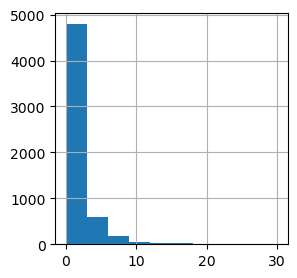

In [25]:
rna = mdatas[0].mod['rna']
rna.to_df()['MLL-AF9'].hist()

0.0    5380
1.0     268
2.0      25
3.0       2
Name: hNGFR, dtype: int64


<Axes: >

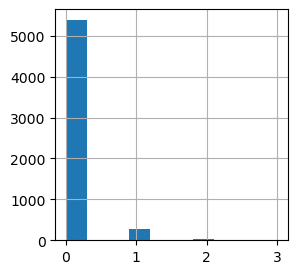

In [26]:
rna = mdatas[0].mod['rna']
print(rna.to_df()['hNGFR'].value_counts())
rna.to_df()['hNGFR'].hist()


In [ ]:
for mdata in mdatas:
    rna = mdata.mod['rna']
    rna.var['mt'] = rna.var_names.str.startswith('mt-') 
    rna.var["ribo"] = rna.var_names.str.startswith(("Rps", "Rpl"))
    rna.var["hb"] = rna.var_names.str.contains(("^Hb[^(p)]"))
    sc.pp.calculate_qc_metrics(rna, qc_vars=['mt', 'ribo', 'hb'], percent_top=None, log1p=False, inplace=True)
    mu.pp.filter_var(rna, 'n_cells_by_counts', lambda x: x >= 30)
    mu.pp.filter_obs(rna, 'n_genes_by_counts', lambda x: (x >= 200) & (x < 5000))
    mu.pp.filter_obs(rna, 'total_counts', lambda x: x < 15000)
    mu.pp.filter_obs(rna, 'pct_counts_mt', lambda x: x < 20)
    rna.layers['counts'] = rna.X.copy() # save the raw counts
    sc.pp.normalize_total(rna, target_sum=1e4)
    sc.pp.log1p(rna) 
    sc.pp.highly_variable_genes(rna, min_mean=0.02, max_mean=4, min_disp=0.5)
    sc.pp.scale(rna, max_value=10)
    sc.tl.pca(rna, svd_solver='arpack')
    sc.pp.neighbors(rna, n_neighbors=10, n_pcs=20)
    # Non-linear dimensionality reduction and clustering
    sc.tl.umap(rna, spread=1., min_dist=.5, random_state=11)
    sc.tl.leiden(rna, resolution=.5)


In [ ]:
for mdata in mdatas:
    atac = mdata.mod['atac']
    sc.pp.calculate_qc_metrics(atac, percent_top=None, log1p=False, inplace=True)
    mu.pp.filter_var(atac, 'n_cells_by_counts', lambda x: x >= 10)
    mu.pp.filter_obs(atac, 'n_genes_by_counts', lambda x: (x >= 2000) & (x <= 15000))
    mu.pp.filter_obs(atac, 'total_counts', lambda x: (x >= 4000) & (x <= 40000))
    atac.layers['counts'] = atac.X.copy() # save the raw counts
    sc.pp.normalize_per_cell(atac, counts_per_cell_after=1e4)
    sc.pp.log1p(atac)
    sc.pp.highly_variable_genes(atac, min_mean=0.05, max_mean=1.5, min_disp=.5)
    sc.pp.scale(atac)
    sc.tl.pca(atac)
    sc.pp.neighbors(atac, n_neighbors=10, n_pcs=30)
    sc.tl.leiden(atac, resolution=.5)
    sc.tl.umap(atac, spread=1.5, min_dist=.5, random_state=20)
    ac.tl.rank_peaks_groups(atac, 'leiden', method='t-test')
    #mu.write("data/pbmc10k.h5mu/atac", atac)


In [ ]:
rows, cols = design.shape
for ii in np.arange(rows):
    mdata = mdatas[ii]
    h5file_save = design.loc[design.index[ii], 'h5file_save']
    mdata.write(h5file_save)
    h5file_save = design.loc[design.index[ii], 'h5file_rna_save']
    mdata.mod['rna'].write(h5file_save)
    h5file_save = design.loc[design.index[ii], 'h5file_atac_save']
    mdata.mod['atac'].write(h5file_save)


In [252]:
mtx.head()

Mrpl15    Lypla1     Tcea1     Rgs20   Atp6v1h  \
AAACCAACAAGTGTTT-1 -0.332687 -0.362266  2.606107 -0.248871 -0.525406   
AAACCAACAGAAATTG-1 -0.332687 -0.362266  1.799627 -0.248871 -0.525406   
AAACCGAAGTTACTTC-1 -0.332687 -0.362266 -0.541489 -0.248871 -0.525406   
AAACGCGCATCAGCAC-1 -0.332687 -0.362266 -0.541489 -0.248871 -0.525406   
AAACGTACAAGCCACT-1 -0.332687 -0.362266  1.358322 -0.248871 -0.525406   

                      Rb1cc1    Pcmtd1    Vcpip1      Sgk3     Snhg6  ...  \
AAACCAACAAGTGTTT-1 -0.822177 -0.631876 -0.478527 -0.611647 -0.344191  ...   
AAACCAACAGAAATTG-1  0.940308 -0.631876 -0.478527 -0.611647 -0.344191  ...   
AAACCGAAGTTACTTC-1 -0.822177  1.296044 -0.478527 -0.611647  3.198039  ...   
AAACGCGCATCAGCAC-1  0.819543  1.198315 -0.478527 -0.611647  3.018477  ...   
AAACGTACAAGCCACT-1 -0.822177  1.677889 -0.478527 -0.611647 -0.344191  ...   

                      mt-Nd3   mt-Nd4l    mt-Nd4    mt-Nd5    mt-Nd6  \
AAACCAACAAGTGTTT-1 -1.673208 -0.896759 -2.146530 -1.262959  1.632402   
AAACCAACAGAAATTG-1  0.142685  0.660264  0.690776  0.026494 -0.586097   
AAACCGAAGTTACTTC-1 -0.476399  0.631022  0.535628  0.506751  0.923859   
AAACGCGCATCAGCAC-1 -0.365569 -0.896759 -0.113937 -0.061859 -0.586097   
AAACGTACAAGCCACT-1 -1.673208 -0.896759 -2.146530 -1.262959 -0.586097   

                     mt-Cytb  CAAA01118383.1     Vamp7     Tmlhe  AC149090.1  
AAACCAACAAGTGTTT-1 -2.346542       -0.490065 -0.271821 -0.290673   -0.904519  
AAACCAACAGAAATTG-1  0.523433       -0.490065 -0.271821 -0.290673   -0.904519  
AAACCGAAGTTACTTC-1  0.437308       -0.490065 -0.271821 -0.290673    0.128739  
AAACGCGCATCAGCAC-1 -0.272379       -0.490065 -0.271821 -0.290673   -0.904519  
AAACGTACAAGCCACT-1 -2.346542       -0.490065 -0.271821 -0.290673   -0.904519  

[5 rows x 9427 columns]

In [281]:
#ii = 7, 8, 10, 12, 14

ii = 13 
ii_sample = design.loc[str(ii + 1), 'sample_name']
print(str(ii) + '\t' + ii_sample)
mtx = mdatas[ii].mod['rna'].to_df()
scrub = scr.Scrublet(mtx) 
doublet_scores, predicted_doublets = scrub.scrub_doublets()
scrublet_df = pd.DataFrame({'doublet_scores' : doublet_scores, 'predicted_doublets' : predicted_doublets}, index = mtx.index)
fname = design.loc[str(ii+1), 'scrublet_rna']
scrublet_df.to_csv(fname)
print(pd.Series(predicted_doublets).value_counts())


13	trp_h90
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.39
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 0.1%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 18.2%
Elapsed time: 25.9 seconds
False    10688
True         1
Name: count, dtype: int64


In [ ]:
# using RNASeq results
for ii in np.arange(design.shape[0]):
    ii_sample = design.loc[str(ii + 1), 'sample_name']
    print(str(ii) + '\t' + ii_sample)
    mtx = mdatas[ii].mod['rna'].to_df()
    scrub = scr.Scrublet(mtx) 
    doublet_scores, predicted_doublets = scrub.scrub_doublets()
    scrublet_df = pd.DataFrame({'doublet_scores' : doublet_scores, 'predicted_doublets' : predicted_doublets}, index = mtx.index)
    fname = design.loc[str(ii+1), 'scrublet_rna']
    scrublet_df.to_csv(fname)
    print(pd.Series(predicted_doublets).value_counts())
    
    

In [282]:
cmd = """
library(data.table)
library(dplyr)
library(SingleCellExperiment)
library(anndata)
library(scDblFinder)

base_dir = '/research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/WenhuoHu/collab_JinWang/'
setwd(base_dir)

design = fread('data/dsn_dt_base_v2.tsv')

args = commandArgs(trailingOnly=TRUE)

ii = as.integer( args[1] )

fname = design[ii, h5file_rna_save]
oo <- read_h5ad(fname)
counts = t(oo$X)
sce = SingleCellExperiment(list(counts = counts))
sce <- scDblFinder(sce, dbr=0.1)

fname = paste0('data2/sce_', ii, '_rna.rds')
saveRDS(sce, file = fname)

"""
fname = base_dir + 'run_scDblFinder.R'
f = open(fname, "w")
f.write(cmd)
f.close()


In [ ]:
# run under scdblet env: 
# mamba install r-SeuratObject=4.1.4 r-Matrix=1.6.1.1 r-seurat=4.4.0
! Rscript run_scDblFinder2.R 1  &> s1_out  &
! Rscript run_scDblFinder2.R 2  &> s2_out  &
! Rscript run_scDblFinder2.R 3  &> s3_out  &
! Rscript run_scDblFinder2.R 4  &> s4_out  &
! Rscript run_scDblFinder2.R 5  &> s5_out  &
! Rscript run_scDblFinder2.R 6  &> s6_out  &
! Rscript run_scDblFinder2.R 7  &> s7_out  &
! Rscript run_scDblFinder2.R 8  &> s8_out  &
! Rscript run_scDblFinder2.R 9  &> s9_out  &
! Rscript run_scDblFinder2.R 10 &> s10_out  &
! Rscript run_scDblFinder2.R 11 &> s11_out  &
! Rscript run_scDblFinder2.R 12 &> s12_out  &
! Rscript run_scDblFinder2.R 13 &> s13_out  &
! Rscript run_scDblFinder2.R 14 &> s14_out  & 
! Rscript run_scDblFinder2.R 15 &> s15_out  &


In [283]:
cmd = """
library(data.table)
library(dplyr)
library(SingleCellExperiment)
library(anndata)
library(scDblFinder)

base_dir = '/research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/WenhuoHu/collab_JinWang/'
setwd(base_dir)

design = fread('data/dsn_dt_base_v2.tsv')

args = commandArgs(trailingOnly=TRUE)

ii = as.integer( args[1] )

fname = design[ii, h5file_atac_save]
oo <- read_h5ad(fname)
counts = t(oo$X)
sce = SingleCellExperiment(list(counts = counts))
sce <- scDblFinder(sce, artificialDoublets=1, aggregateFeatures=TRUE, nfeatures=25, processing="normFeatures")

fname = paste0('data2/sce_', ii, '_atac.rds')
saveRDS(sce, file = fname)

"""

fname = base_dir + 'run_scDblFinder_atac.R'
f = open(fname, "w")
f.write(cmd)
f.close()


In [ ]:
# run under scdblet env: 
# mamba install r-SeuratObject=4.1.4 r-Matrix=1.6.1.1 r-seurat=4.4.0
! Rscript run_scDblFinder_atac.R 1  &> atac_s1_out &
! Rscript run_scDblFinder_atac.R 2  &> atac_s2_out &
! Rscript run_scDblFinder_atac.R 3  &> atac_s3_out &
! Rscript run_scDblFinder_atac.R 4  &> atac_s4_out &
! Rscript run_scDblFinder_atac.R 5  &> atac_s5_out &
! Rscript run_scDblFinder_atac.R 6  &> atac_s6_out &
! Rscript run_scDblFinder_atac.R 7  &> atac_s7_out &
! Rscript run_scDblFinder_atac.R 8  &> atac_s8_out &
! Rscript run_scDblFinder_atac.R 9  &> atac_s9_out &
! Rscript run_scDblFinder_atac.R 10 &> atac_s10_out &
! Rscript run_scDblFinder_atac.R 11 &> atac_s11_out &
! Rscript run_scDblFinder_atac.R 12 &> atac_s12_out &
! Rscript run_scDblFinder_atac.R 13 &> atac_s13_out &
! Rscript run_scDblFinder_atac.R 14 &> atac_s14_out &
! Rscript run_scDblFinder_atac.R 15 &> atac_s15_out &


In [ ]:
# this can run after the next plot section
rows, cols = design.shape
for ii in np.arange(rows):
    mdata = mdatas[ii]
    h5file_save = design.loc[design.index[ii], 'h5file_save']
    mdata.write(h5file_save)


In [12]:
mdatas = [mu.read(fname) for fname in design['h5file_save'] ]


NameError: name 'design' is not defined

In [11]:
mdatas = [mu.read(fname) for fname in design['h5file_save'] ]

In [112]:
tmp = design.loc[design['celltype'] == 'H', ]
tmp.index


Index(['1', '2', '3', '9', '10', '11'], dtype='object')

In [117]:
tmp

sname    group                                            basedir  \
1     H2  iMLLAF9  /research/groups/jxugrp/home/common/Lab_Member...   
2     H3  iMLLAF9  /research/groups/jxugrp/home/common/Lab_Member...   
3     H4  iMLLAF9  /research/groups/jxugrp/home/common/Lab_Member...   
9    h4w     ctrl  /research/groups/jxugrp/home/common/Lab_Member...   
10   h6w     ctrl  /research/groups/jxugrp/home/common/Lab_Member...   
11   h8w     ctrl  /research/groups/jxugrp/home/common/Lab_Member...   

                                               h5file celltype  \
1   /research/groups/jxugrp/home/common/Lab_Member...        H   
2   /research/groups/jxugrp/home/common/Lab_Member...        H   
3   /research/groups/jxugrp/home/common/Lab_Member...        H   
9   /research/groups/jxugrp/home/common/Lab_Member...        H   
10  /research/groups/jxugrp/home/common/Lab_Member...        H   
11  /research/groups/jxugrp/home/common/Lab_Member...        H   

                                          h5file_save  \
1   /research/groups/jxugrp/home/common/Lab_Member...   
2   /research/groups/jxugrp/home/common/Lab_Member...   
3   /research/groups/jxugrp/home/common/Lab_Member...   
9   /research/groups/jxugrp/home/common/Lab_Member...   
10  /research/groups/jxugrp/home/common/Lab_Member...   
11  /research/groups/jxugrp/home/common/Lab_Member...   

                                 h5file_celltype_save  
1   /research/groups/jxugrp/home/common/Lab_Member...  
2   /research/groups/jxugrp/home/common/Lab_Member...  
3   /research/groups/jxugrp/home/common/Lab_Member...  
9   /research/groups/jxugrp/home/common/Lab_Member...  
10  /research/groups/jxugrp/home/common/Lab_Member...  
11  /research/groups/jxugrp/home/common/Lab_Member...

... storing 'feature_types' as categorical
... storing 'genome' as categorical
... storing 'interval' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical
... storing 'interval' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical
... storing 'interval' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical
... storing 'interval' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical
... storing 'interval' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical
... storing 'interval' as categorical


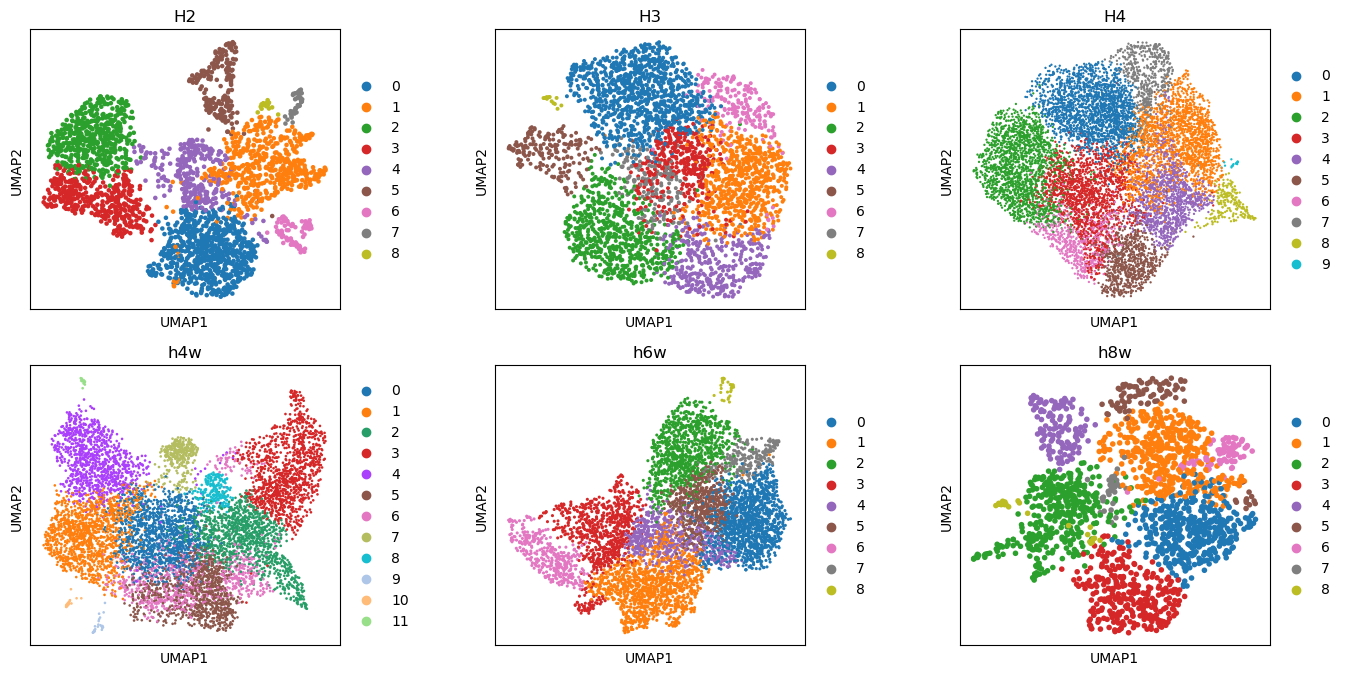

In [120]:
ncols = 3
nrows = 2
figsize = 4
wspace = 0.5
fig, axs = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(ncols * figsize + figsize * wspace * (ncols - 1), nrows * figsize),
)
plt.subplots_adjust(wspace=wspace)

ii = 0 
for rr in np.arange(nrows):
    for cc in np.arange(ncols):
        jj = tmp.index[ii]
        mdata = mdatas[int(jj)-1]
        rna = mdata.mod['rna']
        sc.pl.umap(rna, color="leiden", show = False, ax = axs[rr, cc], title = tmp.loc[jj, 'sname']) 
        ii = ii + 1
        if ii == tmp.shape[0]:
            break


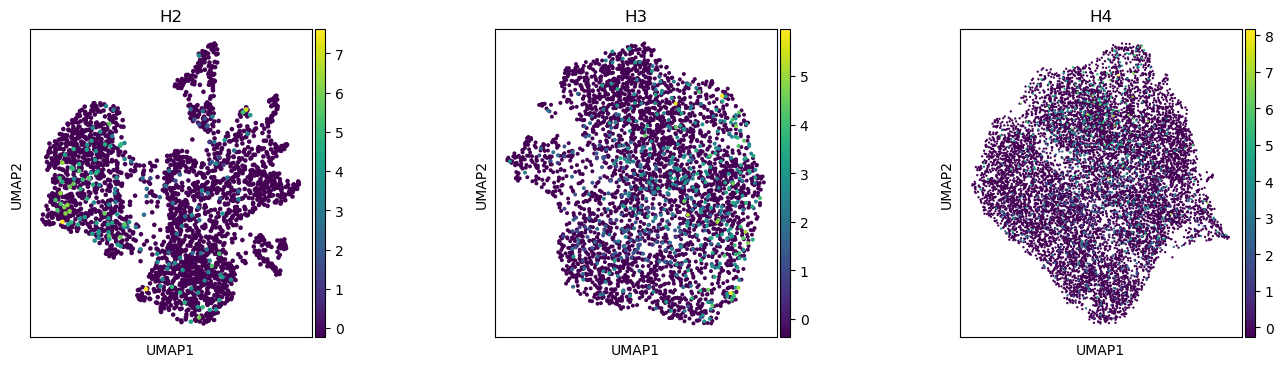

In [126]:
ncols = 3
figsize = 4
wspace = 0.5
fig, axs = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(ncols * figsize + figsize * wspace * (ncols - 1), nrows * figsize),
)
plt.subplots_adjust(wspace=wspace)

ii = 0 
for cc in np.arange(ncols):
    jj = tmp.index[ii]
    mdata = mdatas[int(jj)-1]
    rna = mdata.mod['rna']
    sc.pl.umap(rna, color="hNGFR", show = False, ax = axs[cc], title = tmp.loc[jj, 'sname']) 
    ii = ii + 1
    if ii == tmp.shape[0]:
        break


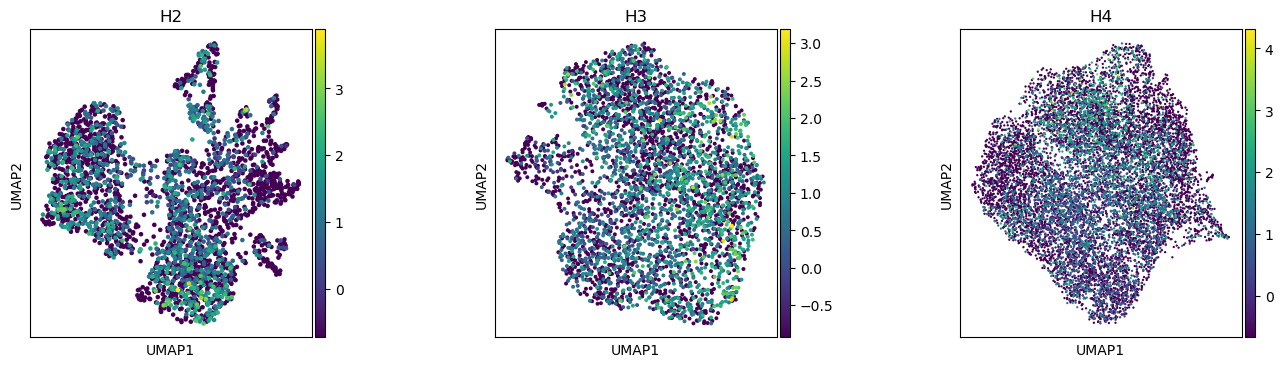

In [127]:
ncols = 3
figsize = 4
wspace = 0.5
fig, axs = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(ncols * figsize + figsize * wspace * (ncols - 1), nrows * figsize),
)
plt.subplots_adjust(wspace=wspace)

ii = 0 
for cc in np.arange(ncols):
    jj = tmp.index[ii]
    mdata = mdatas[int(jj)-1]
    rna = mdata.mod['rna']
    sc.pl.umap(rna, color="MLL-AF9", show = False, ax = axs[cc], title = tmp.loc[jj, 'sname']) 
    ii = ii + 1
    if ii == tmp.shape[0]:
        break


In [143]:
mdatas[0].mod['rna'].to_df().iloc[1:10, 1:10]

Lypla1     Tcea1   Atp6v1h    Rb1cc1  4732440D04Rik  \
AAACAGCCAGCTACGT-1 -0.394849 -0.448623 -0.430929  1.368020      -0.124216   
AAACATGCACCACAAC-1 -0.394849 -0.448623 -0.430929  0.586590      -0.124216   
AAACATGCATAGCTGC-1 -0.394849  1.988248 -0.430929 -0.798776      -0.124216   
AAACCAACAAAGCCTC-1 -0.394849 -0.448623 -0.430929  1.901794      -0.124216   
AAACCAACATGGCCTG-1 -0.394849 -0.448623 -0.430929  1.080890      -0.124216   
AAACCGAAGCTTAGTA-1 -0.394849  1.603826 -0.430929  1.459064      -0.124216   
AAACCGAAGCTTTGGG-1 -0.394849 -0.448623 -0.430929 -0.798776      -0.124216   
AAACCGGCAAGCGAGC-1 -0.394849 -0.448623 -0.430929 -0.798776      -0.124216   
AAACCGGCACAAACTT-1 -0.394849 -0.448623 -0.430929 -0.798776      -0.124216   

                        St18    Pcmtd1   Gm26901      Rrs1  
AAACAGCCAGCTACGT-1 -0.118931 -0.488608 -0.106964 -0.196416  
AAACATGCACCACAAC-1 -0.118931 -0.488608 -0.106964 -0.196416  
AAACATGCATAGCTGC-1  7.098910  0.912442 -0.106964 -0.196416  
AAACCAACAAAGCCTC-1 -0.118931  2.216467 -0.106964 -0.196416  
AAACCAACATGGCCTG-1 -0.118931 -0.488608 -0.106964 -0.196416  
AAACCGAAGCTTAGTA-1 -0.118931  2.004610 -0.106964 -0.196416  
AAACCGAAGCTTTGGG-1 -0.118931 -0.488608 -0.106964 -0.196416  
AAACCGGCAAGCGAGC-1 -0.118931 -0.488608 -0.106964 -0.196416  
AAACCGGCACAAACTT-1 -0.118931 -0.488608 -0.106964 -0.196416

(2779, 11740)


<Axes: >

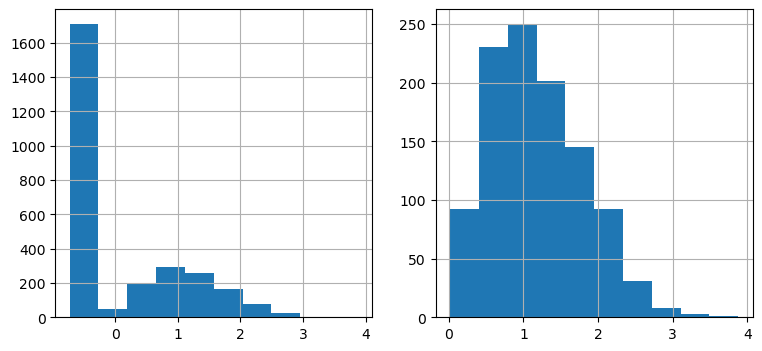

In [168]:
tmp = mdatas[0].mod['rna'].to_df()
print(tmp.shape)
tmp.loc[tmp['MLL-AF9'] > 0, 'MLL-AF9']
fig, axes = plt.subplots(1, 2, figsize = (9,4))
tmp.loc[:, 'MLL-AF9'].hist(ax = axes[0])
tmp.loc[tmp['MLL-AF9'] > 0, 'MLL-AF9'].hist(ax = axes[1])


(2779, 11740)


<Axes: >

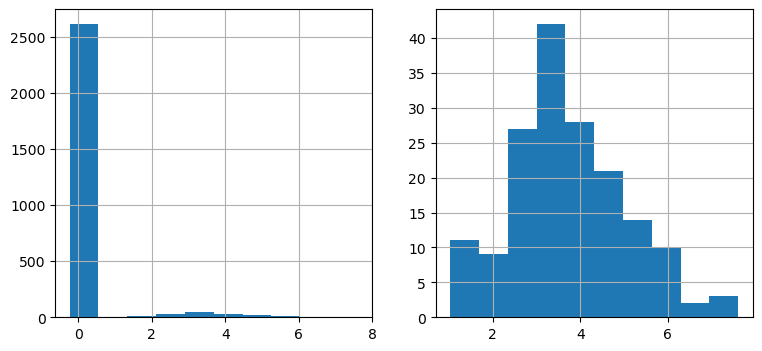

In [167]:
tmp = mdatas[0].mod['rna'].to_df()
print(tmp.shape)
tmp.loc[tmp['hNGFR'] > 0, 'hNGFR']
fig, axes = plt.subplots(1, 2, figsize = (9,4))
tmp.loc[:, 'hNGFR'].hist(ax = axes[0])
tmp.loc[tmp['hNGFR'] > 0, 'hNGFR'].hist(ax = axes[1])


In [195]:
%%R -i tmp -o mm
tmp = as.data.table(tmp, keep.rownames = T)
tmp[, m := `MLL-AF9` > 0]
tmp[, h := `hNGFR` > 0]
table(tmp$m, tmp$h)
mm = tmp[m & h, rn]

In [207]:
mdatas[0].mod['rna'].obs['dp'] = 'low'
obs = mdatas[0].mod['rna'].obs
obs.loc[mm, 'dp'] = 'dp'


<Axes: title={'center': 'hNGFR'}, xlabel='UMAP1', ylabel='UMAP2'>

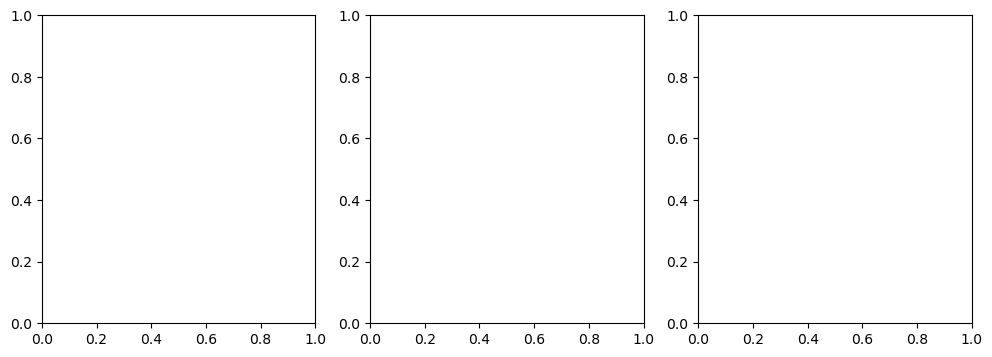

In [214]:
fig, axes = plt.subplots(1, 3, figsize = (12,4))
sc.pl.umap(mdatas[0].mod['rna'], color="hNGFR", show = False, ax = axs[0]) #, title = design.iloc[1, 'sname'])
sc.pl.umap(mdatas[0].mod['rna'], color="hNGFR", show = False, ax = axs[1]) #, title = design.iloc[1, 'sname'])
sc.pl.umap(mdatas[0].mod['rna'], color="hNGFR", show = False, ax = axs[2]) #, title = design.iloc[1, 'sname'])